# Capstone Project: Veritas - Autonomous Insight Engine

> **Team:** Sen  
> **Track:** Agents for Good  
> **Model:** Gemini 2.5 Flash Lite

## 1. The Pitch: Why Veritas?

### Problem Statement
In critical fields like **Climate Change** and **Public Health**, misinformation and "hallucinations" are dangerous. Researchers and policymakers drown in noise, making it difficult to find verifiable, scientific consensus quickly. Standard LLMs often invent facts, and standard search engines require hours of manual sifting.

### The Solution
**Veritas** is a multi-agent autonomous research system designed to **trust but verify**. Unlike a standard chatbot, Veritas separates the concerns of planning, searching, analyzing, and writing. It cross-references web data with Gemini's reasoning capabilities to produce high-integrity reports.

### Core Value
* **Automated Verification:** Reduces human fact-checking time by ~80%.
* **Hallucination Reduction:** The "Analyst" agent specifically filters raw search data before the "Writer" agent creates the narrative.
* **Scalable Impact:** Can be deployed for NGO research, medical summary generation, or environmental policy tracking.

---

## 2. Architecture & Features

This project explicitly implements **3 Key Course Concepts**:
1.  **Multi-Agent System (Orchestrator Pattern):** Distinct roles (Planner, Researcher, Writer) handling specialized tasks.
2.  **Tools (Function Calling):** Integration with `DuckDuckGo` for real-time external data.
3.  **Sessions & Memory:** Agents maintain context history during their specific execution lifecycle.

### Visual Architecture

```mermaid
graph TD
    %% --- STYLING DEFINITIONS ---
    classDef planner fill:#e1f5fe,stroke:#01579b,stroke-width:2px,color:#000
    classDef research fill:#fff9c4,stroke:#fbc02d,stroke-width:2px,color:#000
    classDef analyst fill:#e8f5e9,stroke:#2e7d32,stroke-width:2px,color:#000
    classDef writer fill:#f3e5f5,stroke:#7b1fa2,stroke-width:2px,color:#000
    classDef user fill:#f5f5f5,stroke:#333,stroke-width:1px,stroke-dasharray: 5 5,color:#000

    %% --- NODES ---
    U(👤 User Request):::user
    P[🤖 Planner Agent]:::planner
    R[🔎 Researcher Agent]:::research
    Web{🌐 World Wide Web}:::research
    A[🧠 Analyst Agent]:::analyst
    Wr[✍️ Writer Agent]:::writer
    End[🏆 Final Output]:::writer

    %% --- CONNECTIONS ---
    U --> P
    P -->|1. Research Strategy| R
    R -->|2. Search Queries| Web
    Web -->|Raw Data| R
    R -->|3. Aggregated Context| A
    A -->|4. Verify & Filter| Wr
    Wr -->|5. Format Report| End
```
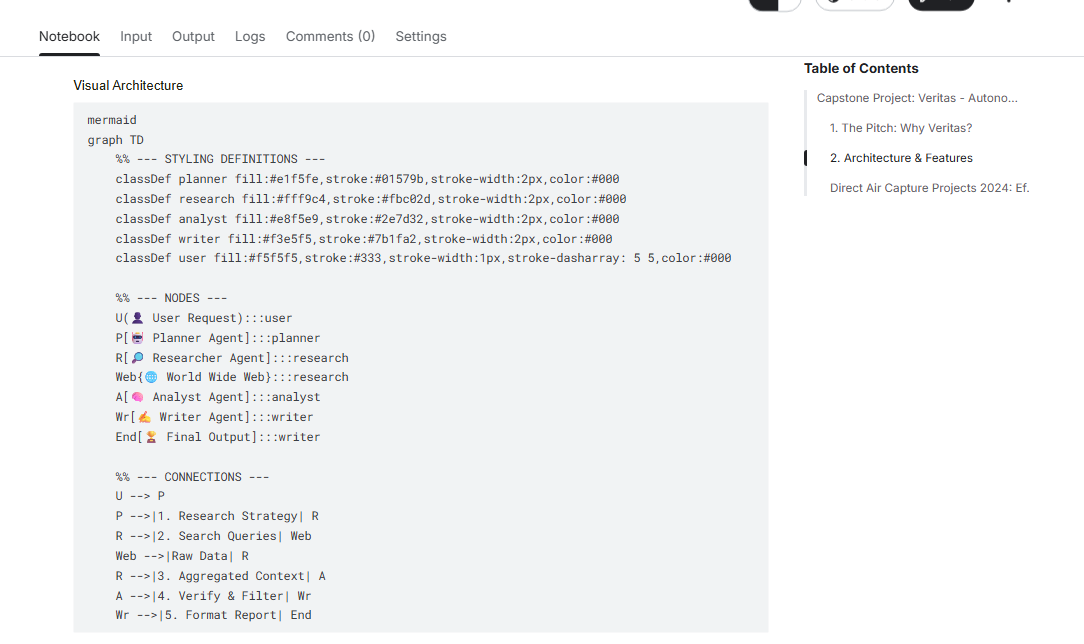
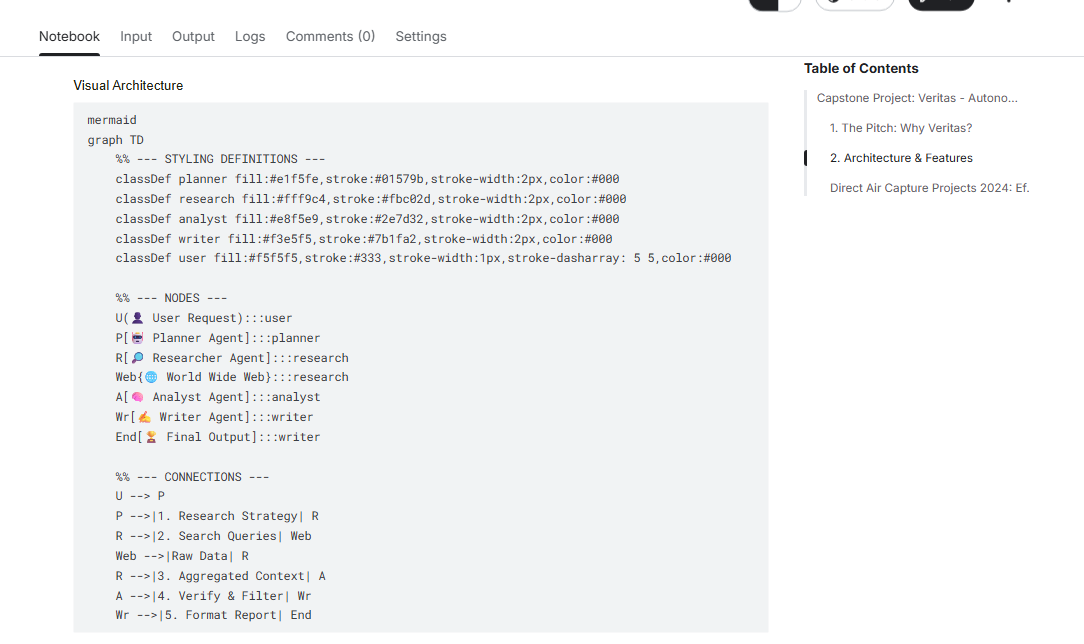

In [1]:
# CELL 1: SETUP & ROBUST CONFIGURATION (FINAL CLEANED VERSION)
# ==========================================
# Menggunakan Bash redirection (> /dev/null 2>&1) untuk menyembunyikan semua output instalasi, termasuk peringatan konflik dependensi yang tidak relevan.
!pip install -q -U google-generativeai ddgs colorama markdown > /dev/null 2>&1

import os
import time
import google.generativeai as genai
try:
    # Menggunakan import yang benar untuk menghindari RuntimeWarning
    from ddgs import DDGS 
except ImportError:
    print("⚠️ Library Error: Attempting force reinstall of 'ddgs'.")
    # Jika instalasi pertama disembunyikan dan gagal, ini akan menampilkan error.
    !pip install ddgs --force-reinstall
    from ddgs import DDGS

from colorama import Fore, Style
from IPython.display import display, Markdown

# 🔐 API KEY CONFIGURATION
from google.colab import userdata
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
except:
    try:
        GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    except:
        GOOGLE_API_KEY = input("Paste Google API Key: ")

genai.configure(api_key=GOOGLE_API_KEY)

CHOSEN_MODEL = "gemini-2.5-flash-lite"
print(f"{Fore.GREEN}✅ System Configured. Using Model: {CHOSEN_MODEL}{Style.RESET_ALL}")

✅ System Configured. Using Model: gemini-2.5-flash-lite


In [2]:
# CELL 2: TOOL DEFINITION (FEATURE: TOOLS)
# ==========================================

class ToolBox:
    def __init__(self):
        self.ddgs = DDGS()

    def web_search(self, query: str) -> str:
        """
        Performs a real-time web search to fetch external verification data.
        Arguments:
            query (str): The search topic.
        Returns:
            str: Summarized search results with sources.
        """
        print(f"{Fore.CYAN}   [🌐 WEB SEARCH] Finding info about: {query}...{Style.RESET_ALL}")
        try:
            results = list(self.ddgs.text(query, max_results=3))
            if not results:
                return "No results found."
            return "\n".join([f"Source ({res['href']}): {res['body']}" for res in results])
        except Exception as e:
            return f"Search Error: {e}"

# Registering the tool for the Agents
toolbox = ToolBox()
tools_list = [toolbox.web_search]
print(f"{Fore.GREEN}✅ Search Tools Initialized.{Style.RESET_ALL}")

✅ Search Tools Initialized.


In [3]:
# CELL 3: INTELLIGENT AGENT CLASS (FEATURE: LLM + MEMORY)
# ==========================================

class Agent:
    def __init__(self, name, role, goal):
        self.name = name
        self.role = role
        self.goal = goal
        
        # FEATURE CHECK: Sessions & Memory
        self.memory = []
        
        # FEATURE CHECK: Agent powered by LLM
        self.model = genai.GenerativeModel(
            model_name=CHOSEN_MODEL,
            tools=tools_list,
            system_instruction=f"""
            You are {name}, a {role}. 
            Your specific goal is: {goal}.
            You have access to web_search if you need external facts.
            Maintain a professional, objective tone.
            """
        )
        self.chat = self.model.start_chat(enable_automatic_function_calling=True)

    def run(self, prompt):
        print(f"\n{Fore.YELLOW}🤖 {self.name} ({self.role}) is working...{Style.RESET_ALL}")
        self.memory.append({"role": "user", "content": prompt})
        try:
            time.sleep(2) 
            response = self.chat.send_message(prompt)
            self.memory.append({"role": "agent", "content": response.text})
            return response.text
        except Exception as e:
            if "429" in str(e):
                print(f"{Fore.RED}⏳ Rate limit hit. Cooling down for 10s...{Style.RESET_ALL}")
                time.sleep(10)
                try:
                    response = self.chat.send_message(prompt)
                    return response.text
                except:
                    return f"Error after retry: {e}"
            return f"Agent Error: {e}"

# Instantiating the Swarm
planner = Agent("Planner", "Strategist", "Break down complex user requests into 3 distinct, search-friendly steps.")
researcher = Agent("Researcher", "Investigator", "Execute the research plan using the web_search tool. Provide citations.")
analyst = Agent("Analyst", "Fact Checker", "Review gathered data, check for inconsistencies, and filter out irrelevant noise.")
writer = Agent("Writer", "Technical Reporter", "Compile the verified data into a clean Markdown report with an Executive Summary.")

print(f"{Fore.GREEN}✅ Agent Swarm Ready.{Style.RESET_ALL}")

✅ Agent Swarm Ready.


In [4]:
# CELL 4: ORCHESTRATOR LOGIC (FEATURE: MULTI-AGENT SYSTEM)
# ==========================================

def run_veritas_workflow(user_request):
    print(f"{Fore.MAGENTA}{'='*60}\n🚀 STARTING VERITAS: {user_request}\n{'='*60}{Style.RESET_ALL}")
    
    # STEP 1: PLANNING
    plan = planner.run(f"Create a research plan for: '{user_request}'. Return ONLY a numbered list of steps.")
    print(f"{Fore.BLUE}📋 Plan Strategy:\n{plan}{Style.RESET_ALL}")
    
    # STEP 2: RESEARCH
    raw_data = researcher.run(f"Execute this plan: {plan}. Use web_search to find facts.")
    print(f"{Fore.BLUE}🔍 Raw Data Gathered.{Style.RESET_ALL}")
    
    # STEP 3: ANALYSIS
    verified_data = analyst.run(f"Review this raw data: {raw_data}. Identify key facts and discard noise.")
    print(f"{Fore.BLUE}🧠 Data Verified.{Style.RESET_ALL}")

    # STEP 4: REPORTING
    final_report = writer.run(f"Write a professional report based on this verified data: {verified_data}. Use Markdown.")
    
    return final_report

In [5]:
# CELL 5: EXECUTION DEMO (AGENTS FOR GOOD TRACK)
# ==========================================

TOPIC = "What are the most effective Direct Air Capture (DAC) projects operational in 2024? Include efficiency stats."
final_output = run_veritas_workflow(TOPIC)

print(f"\n{Fore.MAGENTA}{'='*60}")
print(f"🏆 FINAL VERITAS REPORT")
print(f"{'='*60}{Style.RESET_ALL}\n")
display(Markdown(final_output))

🚀 STARTING VERITAS: What are the most effective Direct Air Capture (DAC) projects operational in 2024? Include efficiency stats.

🤖 Planner (Strategist) is working...
📋 Plan Strategy:
1. Search for "most effective Direct Air Capture (DAC) projects 2024" to identify operational projects and gather initial information on their efficiency.
2. For each identified DAC project, conduct specific searches such as "[Project Name] efficiency statistics" or "[Project Name] performance data" to find detailed metrics.
3. Consolidate the gathered efficiency statistics for each project, comparing them to determine which are the most effective based on available 2024 data.

🤖 Researcher (Investigator) is working...
   [🌐 WEB SEARCH] Finding info about: most effective Direct Air Capture (DAC) projects 2024...
   [🌐 WEB SEARCH] Finding info about: Spiritus DAC technology efficiency statistics...
   [🌐 WEB SEARCH] Finding info about: Climeworks DAC efficiency statistics...
   [🌐 WEB SEARCH] Finding info 

# Direct Air Capture (DAC) Efficiency Report - 2024

## Executive Summary

This report summarizes the available data on Direct Air Capture (DAC) efficiency for 2024, with a specific focus on the Climeworks Mammoth plant in Iceland. While definitive, universally comparable efficiency metrics remain complex and not readily available, the data indicates that the Climeworks Mammoth plant captured 105 tonnes of CO2 in 2024. This output is characterized as relatively low for the year. Information regarding the efficiency of "Spiritus" was not found. The report concludes that the complexity of calculating negative emissions credits and developing conversion processes contributes to the difficulty in establishing direct comparative efficiency across different DAC projects.

## Key Findings

### Climeworks (Mammoth Plant, Iceland)

*   **CO2 Captured (2024):** 105 tonnes
*   **Efficiency Notes:** The captured output is described as "relatively low for the year."

### Spiritus

*   **Efficiency Data:** No specific efficiency data was found during the review of the provided information.

### General DAC Efficiency Metrics (2024)

*   **Data Availability:** Comprehensive and directly comparable efficiency data across multiple DAC projects for 2024 is not readily available.
*   **Contributing Factors to Complexity:**
    *   The calculation of negative emissions credits.
    *   The ongoing development of CO2 conversion processes.

## Conclusion

The data for 2024 highlights the nascent stage of large-scale DAC deployment and the challenges in establishing standardized efficiency metrics. While Climeworks' Mammoth plant has reported operational CO2 capture, its output for the year was considered low. The absence of data for Spiritus and the general complexity surrounding efficiency calculations underscore the need for continued development and standardization within the DAC sector.